In [12]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import ResNet50, EfficientNetB0, InceptionV3, MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split

print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 1. Pull Dataset from Kaggle

In [13]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files

file_path = '/content/drive/MyDrive/bird_sensor/kaggle.json'

if not os.path.exists(file_path):
  print(f"File '{file_path}' not found. Please upload it.")
  uploaded = files.upload()
  for filename in uploaded.keys():
    if filename == 'kaggle.json':  # Check if uploaded file is 'kaggle.json'
      # Move the uploaded file to the desired location in Google Drive
      # Use shutil.move to move the file (renames if the destination exists)
      shutil.move(filename, file_path)
      print(f'Uploaded and moved {filename} to {file_path}')
      break  # Stop after processing 'kaggle.json'
    else:
      print(f"Uploaded file '{filename}' is not 'kaggle.json'. Please upload the correct file.")
else:
  print(f"File '{file_path}' already exists. Skipping upload.")

# Set up the Kaggle API configuration
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/bird_sensor/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Step 2: Download the dataset
# Replace 'your-kaggle-dataset-name' with the specific dataset name from Kaggle
!kaggle datasets download -d sf-bay-backyard-animals

# Step 3: Unzip the dataset
!unzip sf-bay-backyard-animals -d dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File '/content/drive/MyDrive/bird_sensor/kaggle.json' already exists. Skipping upload.
Dataset URL: https://www.kaggle.com/datasets/andrewmquintana/sf-bay-backyard-animals
License(s): unknown
sf-bay-backyard-animals.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  sf-bay-backyard-animals.zip
replace dataset/sf_animals/029.American_Crow/American_Crow_0001_25053.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## 2. Train a Deep Learning Classification Model (CNN)

### Data Preparation

In [19]:
# Path to your dataset directory
data_dir = 'dataset/sf_animals'

# Create a DataFrame with file paths and labels
filepaths = []
labels = []

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        for filename in os.listdir(class_dir):
            filepaths.append(os.path.join(class_dir, filename))
            labels.append(class_name)

# Create a DataFrame
data = pd.DataFrame({
    'filepath': filepaths,
    'label': labels
})

# Display the first few rows
print(data.head())

                                            filepath              label
0  dataset/sf_animals/029.American_Crow/American_...  029.American_Crow
1  dataset/sf_animals/029.American_Crow/American_...  029.American_Crow
2  dataset/sf_animals/029.American_Crow/American_...  029.American_Crow
3  dataset/sf_animals/029.American_Crow/American_...  029.American_Crow
4  dataset/sf_animals/029.American_Crow/American_...  029.American_Crow


In [26]:
# Split the data into train (70%) and temp (30%)
train_data, temp_data = train_test_split(data, test_size=0.3, stratify=data['label'], random_state=42)

# Further split temp into validation (20%) and test (10%)
val_data, test_data = train_test_split(temp_data, test_size=0.333, stratify=temp_data['label'], random_state=42)

# Print the sizes of each split
print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")

Training samples: 168
Validation samples: 48
Test samples: 24


In [27]:
# Create ImageDataGenerator instances
input_shape = (128, 128, 3)
datagen = ImageDataGenerator(rescale=1.0 / 255)

# Training generator
train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='filepath',
    y_col='label',
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='categorical'
)

# Validation generator
validation_generator = datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col='filepath',
    y_col='label',
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='categorical'
)

# Test generator
test_generator = datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='filepath',
    y_col='label',
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Ensure consistent order for testing
)

num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")

Found 168 validated image filenames belonging to 4 classes.
Found 48 validated image filenames belonging to 4 classes.
Found 24 validated image filenames belonging to 4 classes.
Number of classes: 4


## Deep Learning - Transfer Learning & Hyperparameter Tuning

In [28]:
# Set initial hyperparameters
initial_learning_rate = 1e-3
dropout_rate = 0.5
epochs_initial = 5
input_shape = (128, 128, 3)

# Performance tracking
training_times = {}
peak_accuracy = {}

def plot_model_performance(history_output, model_name):

  # Plot training & validation accuracy
  plt.figure()
  plt.plot(history_output.history['accuracy'], label='Train Accuracy')
  plt.plot(history_output.history['val_accuracy'], label='Val Accuracy')
  plt.title(f'Model Accuracy (Initial Training) for {model_name}')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)
  plt.show()

  # Plot training & validation loss
  plt.figure()
  plt.plot(history_output.history['loss'], label='Train Loss')
  plt.plot(history_output.history['val_loss'], label='Val Loss')
  plt.title(f'Model Loss (Initial Training) for {model_name}')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.show()

# Plot training time comparison
def plot_training_times(training_times):
    model_names = list(training_times.keys())
    times = list(training_times.values())

    plt.figure(figsize=(10, 6))
    plt.bar(model_names, times, color='skyblue')
    plt.title('Training Time Comparison', fontsize=16)
    plt.xlabel('Model', fontsize=14)
    plt.ylabel('Training Time (seconds)', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot peak performance bar graph
def plot_peak_accuracy(peak_performance):
    model_names = list(peak_performance.keys())
    accuracies = list(peak_performance.values())

    plt.figure(figsize=(10, 6))
    plt.bar(model_names, accuracies, color='lightgreen')
    plt.title('Peak Validation Accuracy Comparison', fontsize=16)
    plt.xlabel('Model', fontsize=14)
    plt.ylabel('Peak Validation Accuracy', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

### Model Comparison
1.	Basic CNN: Being a common type of model used for classification, this will be used to establish a baseline performance for this application, allowing for a direct comparison with more complex models and understanding the need for advanced architectures.
2.	ResNet50: With its residual connections, addresses vanishing gradient issues in deep networks and is well-suited for extracting hierarchical features in datasets with complex patterns. If hierarchical features can be established in the birds, this would be a great setup, however, it may not be the best for an initial 4 set of classes.
3.	EfficientNetB0: Balances accuracy and computational efficiency, making it a strong candidate for applications where both performance and resource constraints must be optimized. When I'm retraining for new classes, as they're observed, I don't want the training to take too long.
4.	MobileNetV2: With its lightweight architecture, is ideal for applications requiring high-speed inference and is particularly effective for feature extraction in transfer learning scenarios. The feature extraction ability should make this very effective for the classification of these animals.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training Basic CNN...
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 899ms/step - accuracy: 0.2319 - loss: 4.1106 - val_accuracy: 0.2500 - val_loss: 1.4871
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.3275 - loss: 1.4261 - val_accuracy: 0.3542 - val_loss: 1.3592
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.4807 - loss: 1.3016 - val_accuracy: 0.5208 - val_loss: 1.3078
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.6358 - loss: 1.1705 - val_accuracy: 0.3333 - val_loss: 1.2694
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5986 - loss: 1.0766 - val_accuracy: 0.6667 - val_loss: 1.1184


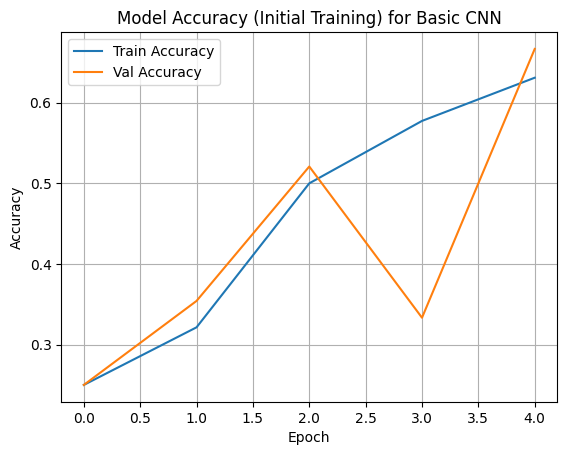

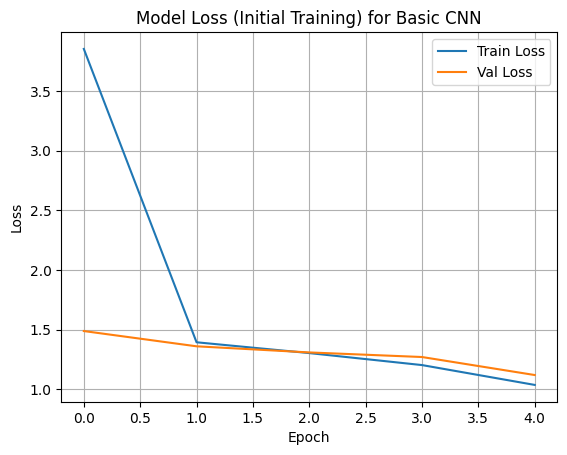

Training ResNet50...
Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.2377 - loss: 1.9408 - val_accuracy: 0.2500 - val_loss: 1.8292
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.5602 - loss: 1.1211 - val_accuracy: 0.2500 - val_loss: 2.1404
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.6116 - loss: 1.0038 - val_accuracy: 0.2500 - val_loss: 2.3816
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.5652 - loss: 0.9992 - val_accuracy: 0.2500 - val_loss: 2.3044
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.6718 - loss: 0.8841 - val_accuracy: 0.2708 - val_loss: 1.9433


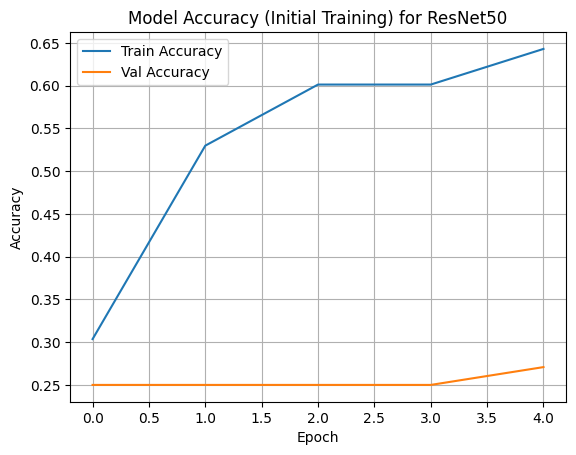

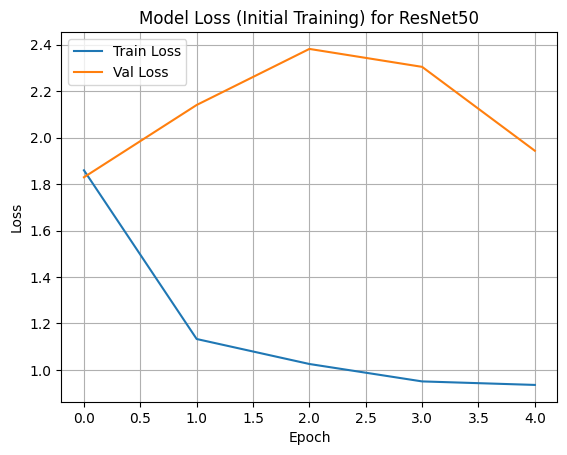

Training EfficientNetB0...
Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 46s 5s/step - accuracy: 0.2354 - loss: 2.0918 - val_accuracy: 0.2500 - val_loss: 13.4727
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.2240 - loss: 1.8429 - val_accuracy: 0.2500 - val_loss: 15.6622
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.1865 - loss: 1.7868 - val_accuracy: 0.2500 - val_loss: 13.0272
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.2708 - loss: 1.6768 - val_accuracy: 0.2500 - val_loss: 10.9394
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.2886 - loss: 1.6303 - val_accuracy: 0.2500 - val_loss: 9.2314


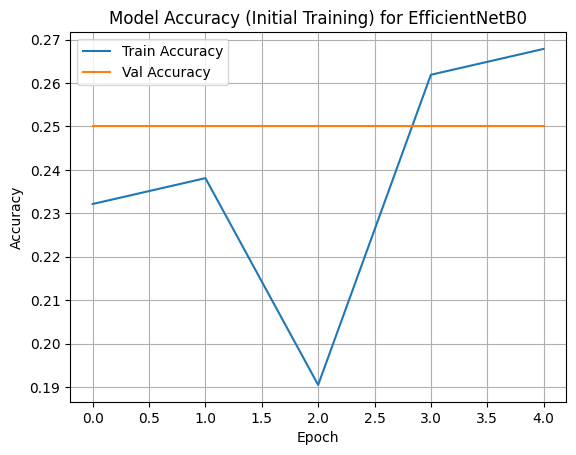

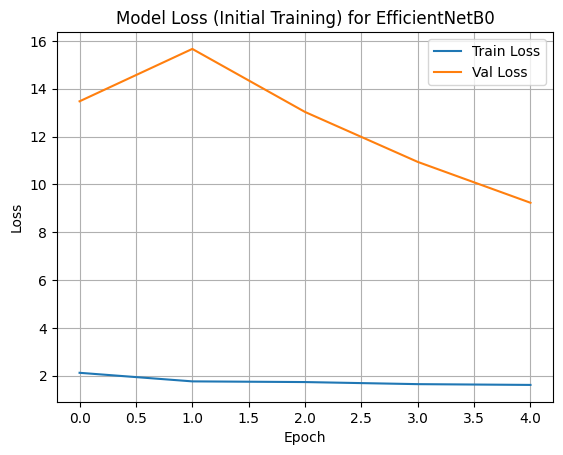

Training MobileNetV2...
Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.5694 - loss: 1.2425 - val_accuracy: 0.7083 - val_loss: 2.1967
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.9575 - loss: 0.1314 - val_accuracy: 0.8125 - val_loss: 0.9793
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9972 - loss: 0.0540 - val_accuracy: 0.8750 - val_loss: 0.5020
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 0.0175 - val_accuracy: 0.9167 - val_loss: 0.3951
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9959 - loss: 0.0258 - val_accuracy: 0.9375 - val_loss: 0.3413


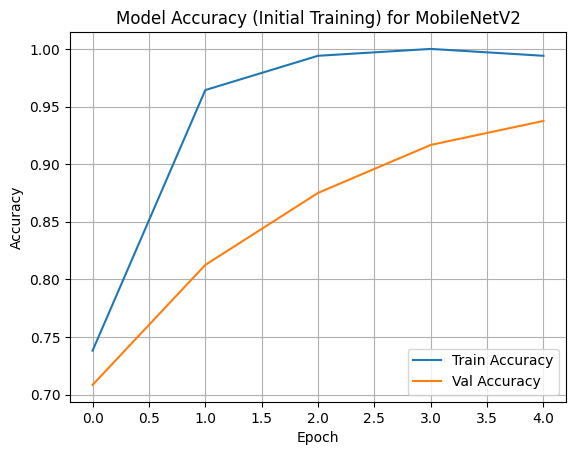

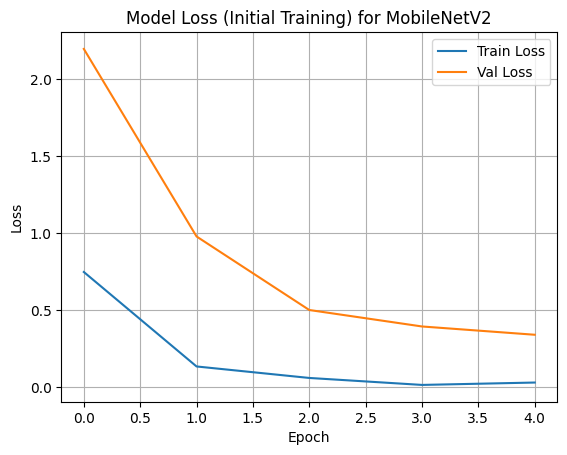

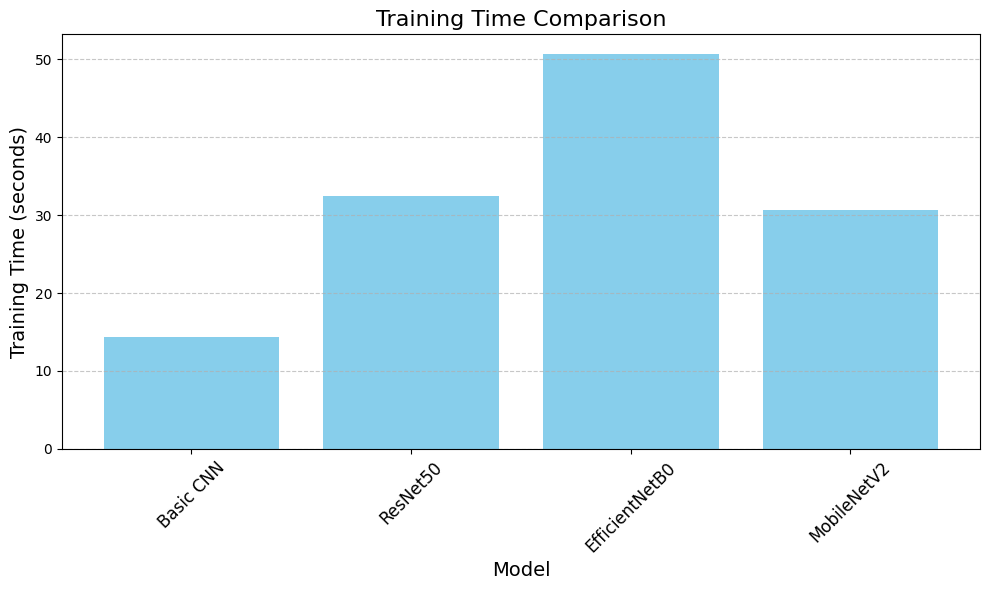

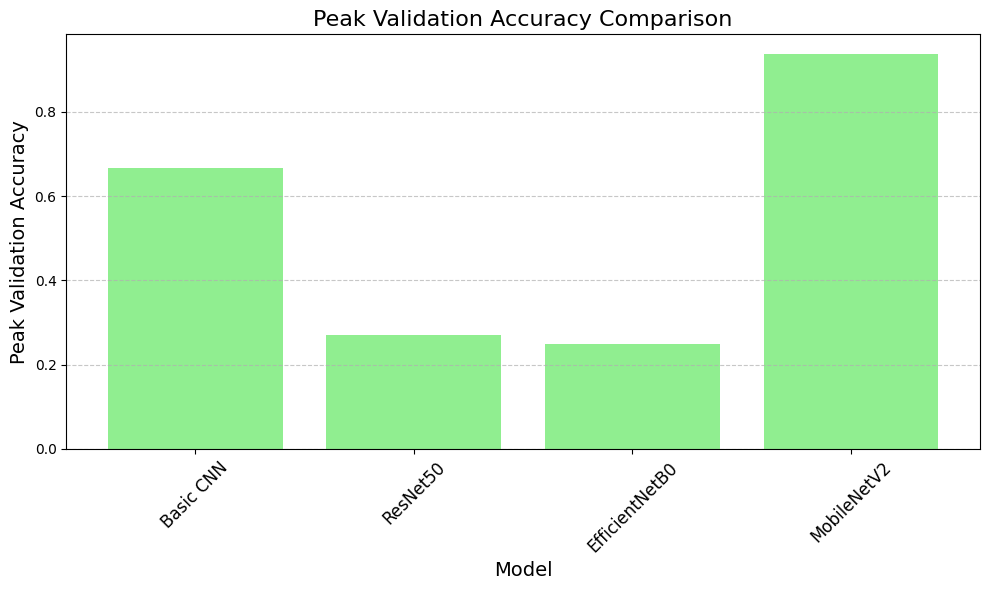

In [31]:
# Create a basic CNN
def build_basic_cnn():
    global input_shape, num_classes
    model = Sequential([
      Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
      MaxPooling2D((2, 2)),
      Conv2D(64, (3, 3), activation='relu'),
      MaxPooling2D((2, 2)),
      Flatten(),
      Dense(128, activation='relu'),
      Dropout(dropout_rate),
      Dense(num_classes, activation='softmax')
    ])
    return model

# Pre-trained models
def build_transfer_learning_model(base_model_class, include_top=False):
    global input_shape, num_classes
    base_model = base_model_class(weights='imagenet', include_top=include_top, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)

# Train and evaluate models
def train_and_evaluate_model(model, model_name):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    start_time = time.time()
    history = model.fit(train_generator, epochs=epochs_initial, validation_data=validation_generator, verbose=1)
    end_time = time.time()

    # Record peak validation accuracy
    peak_accuracy[model_name] = max(history.history['val_accuracy'])

    # Record traning time
    training_time = end_time - start_time
    training_times[model_name] = training_time

    plot_model_performance(history, model_name)

# Main loop to test all models
models = {
    "Basic CNN": build_basic_cnn(),
    "ResNet50": build_transfer_learning_model(ResNet50),
    "EfficientNetB0": build_transfer_learning_model(EfficientNetB0),
    "MobileNetV2": build_transfer_learning_model(MobileNetV2),
}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    train_and_evaluate_model(model, model_name)

# Plot the performance
plot_training_times(training_times)
plot_peak_accuracy(peak_accuracy)

### Freeze Early Layers and Iterate to Determine Baseline
With MobileNetV2 performing incredibly well, reaching 88% validation accuracy and 100% training accuracy, this is going to be the model used moving forward.

#### Reducing Complexity via Layer Density
The strong accuracy was paired with significant overfitting. To address this, the layer density will be reduced to reduce complexity of the architecture.

In [ ]:

# Load MobileNetV2 with pre-trained weights
model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze all layers initially
model.trainable = False

# Build the transfer learning model
inputs = Input(shape=input_shape)
x = model(inputs, training=False)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=initial_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Initial training with frozen base
iteration_history = model.fit(
    train_generator,
    epochs=epochs_initial,
    validation_data=validation_generator
)

# Plot model's performance
plot_model_performance(iteration_history, "MobileNetV2 w Batch Normalization")

#### Further Reduction in Complexity via Layer Density
With the strong performance, reducing layer density further to see if performance improves, again.

In [ ]:

# Load MobileNetV2 with pre-trained weights
model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze all layers initially
model.trainable = False

# Build the transfer learning model
inputs = Input(shape=input_shape)
x = model(inputs, training=False)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=initial_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Initial training with frozen base
iteration_history = model.fit(
    train_generator,
    epochs=epochs_initial,
    validation_data=validation_generator
)

# Plot model's performance
plot_model_performance(iteration_history, "MobileNetV2 w Batch Normalization")

#### Adding Complexity via Layer Depth
Adding a layer to with the maximum being the previous density may help improve the performance while indicating whether or not a deeper architecture will improve performance.

In [ ]:

# Load MobileNetV2 with pre-trained weights
model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze all layers initially
model.trainable = False

# Build the transfer learning model
inputs = Input(shape=input_shape)
x = model(inputs, training=False)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
x = Dense(16, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=initial_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Initial training with frozen base
iteration_history = model.fit(
    train_generator,
    epochs=epochs_initial,
    validation_data=validation_generator
)

# Plot model's performance
plot_model_performance(iteration_history, "MobileNetV2 w Batch Normalization")

### Unfreeze Layers and Fine Tuning

#### Ideal Base Model Training

Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.5689 - loss: 1.3333 - val_accuracy: 0.9167 - val_loss: 0.2222
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.9412 - loss: 0.1664 - val_accuracy: 0.9375 - val_loss: 0.1474
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9774 - loss: 0.1219 - val_accuracy: 0.9583 - val_loss: 0.1001
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9739 - loss: 0.0755 - val_accuracy: 0.9583 - val_loss: 0.0979
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9883 - loss: 0.0675 - val_accuracy: 0.9583 - val_loss: 0.0933


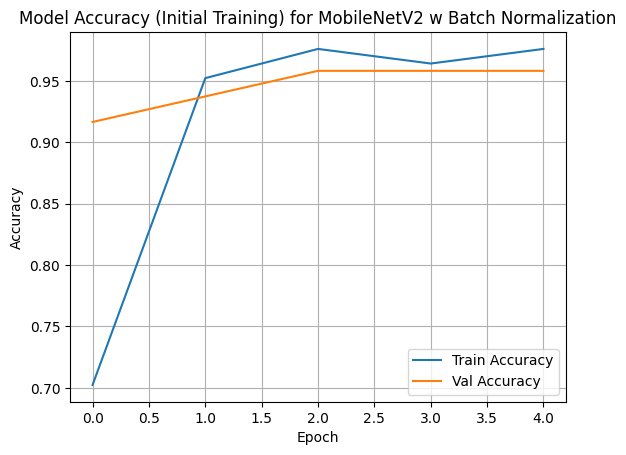

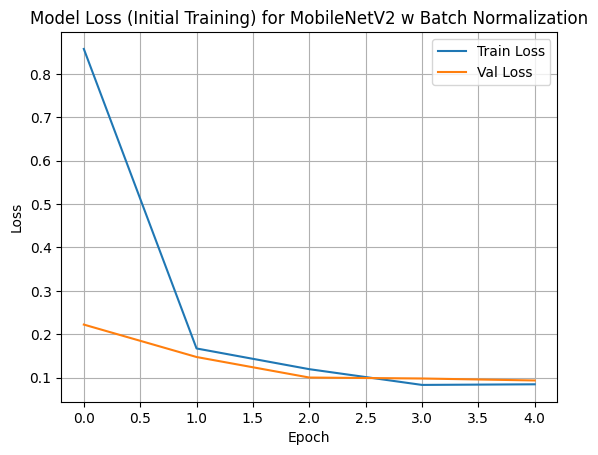

In [32]:
# Load MobileNetV2 with pre-trained weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze all layers initially
base_model.trainable = False

# Build the transfer learning model
inputs = Input(shape=input_shape)
x = base_model(inputs, training=False)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
outputs = Dense(num_classes, activation='softmax')(x)

# Create the complete model
model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=initial_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with the frozen base
iteration_history = model.fit(
    train_generator,
    epochs=epochs_initial,
    validation_data=validation_generator
)

# Plot model's performance
plot_model_performance(iteration_history, "MobileNetV2 w Batch Normalization")


#### Fine Tuning

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.9503 - loss: 0.1715 - val_accuracy: 0.8958 - val_loss: 0.1787 - learning_rate: 1.0000e-04
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - accuracy: 0.9770 - loss: 0.0848 - val_accuracy: 0.8958 - val_loss: 0.2207 - learning_rate: 1.0000e-04
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9983 - loss: 0.0564 - val_accuracy: 0.9375 - val_loss: 0.1240 - learning_rate: 1.0000e-04
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.9801 - loss: 0.0834 - val_accuracy: 0.9375 - val_loss: 0.0972 - learning_rate: 1.0000e-04
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 0.0498 - val_accuracy: 0.9375 - val_loss: 0.0862 - learning_rate: 1.0000e-04
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 0.0363 - val_accuracy: 0.9375 - val_loss: 0.0809 - learning_rate: 1.0000e-04
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 0.034

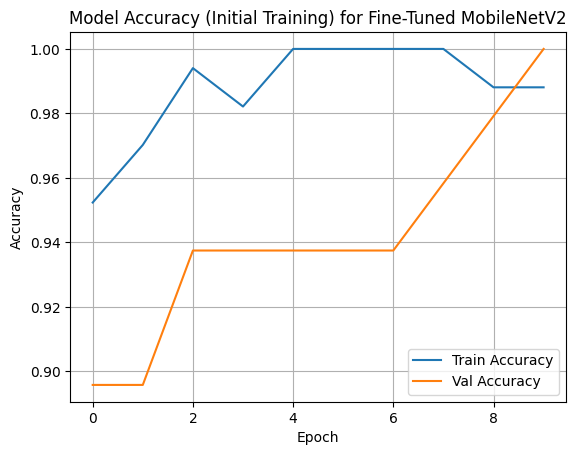

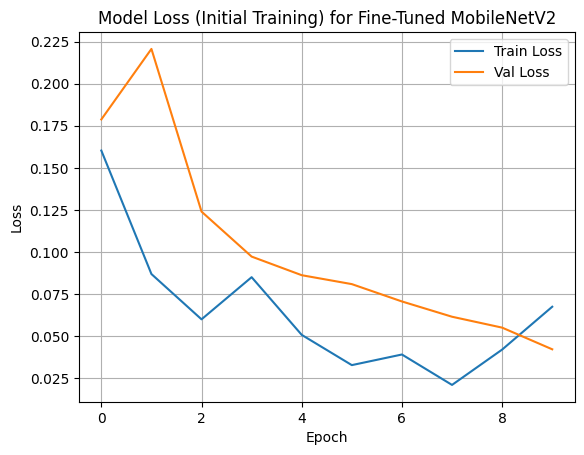

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0525
Test Accuracy: 1.00, Test Loss: 0.05


In [33]:
# Unfreeze specific layers for fine-tuning
fine_tune_at = 100
base_model.trainable = True

# Freeze layers before the fine-tuning point
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Re-compile the model with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=initial_learning_rate / 10),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the model
fine_tune_history = model.fit(
    train_generator,
    epochs=10,  # Fine-tune for more epochs
    validation_data=validation_generator,
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ]
)

# Plot the fine-tuned model's performance
plot_model_performance(fine_tune_history, "Fine-Tuned MobileNetV2")

# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}, Test Loss: {test_loss:.2f}")

Validation loss steadily decreases and the accuracy reaches 100% which is incredible. There is effective learning and generalization. Running a test dataset to ensure performance before hyperparameter tuning to optimize training for future retraining efforts (as new classes present themselves).

### Performance Checkpoint - Architecture Definition and Training

In [34]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 1.0000 - loss: 0.0525
Test Loss: 0.0525
Test Accuracy: 1.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
                      precision    recall  f1-score   support

   029.American_Crow       1.00      1.00      1.00         6
067.Anna_Hummingbird       1.00      1.00      1.00         6
     074.Florida_Jay       1.00      1.00      1.00         6
 076.Dark_eyed_Junco       1.00      1.00      1.00         6

            accuracy                           1.00        24
           macro avg       1.00      1.00      1.00        24
        weighted avg       1.00      1.00      1.00        24



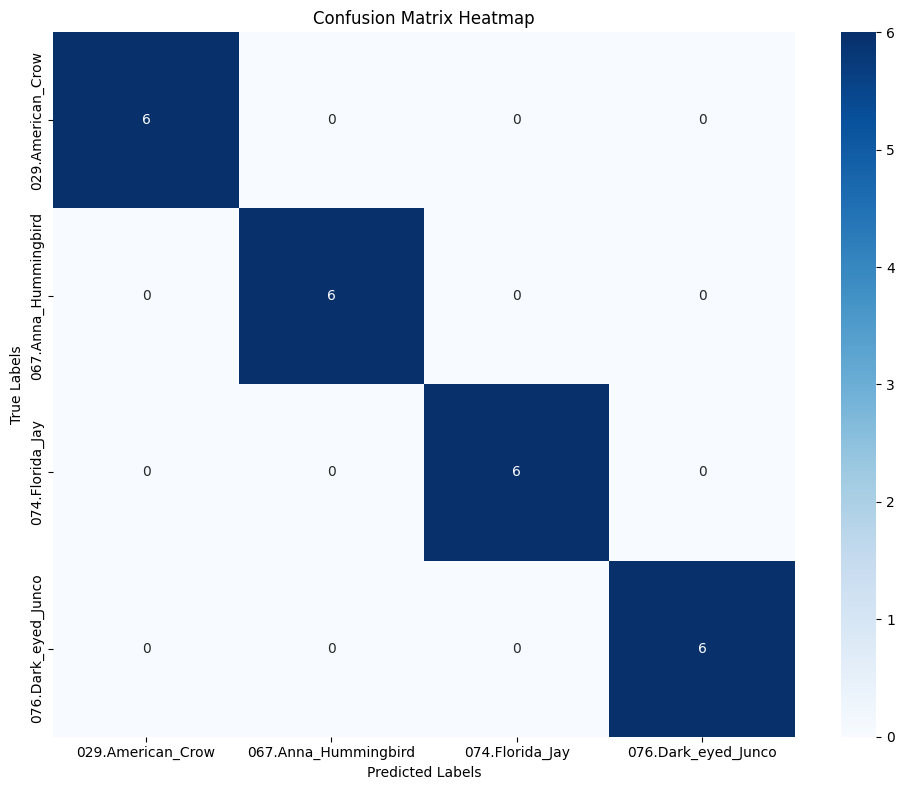

In [38]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get true labels and predicted labels
true_labels = test_generator.classes
predicted_probabilities = model.predict(test_generator)
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Print classification report
target_names = list(test_generator.class_indices.keys())  # Get class names
print(classification_report(true_labels, predicted_labels, target_names=target_names))

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
def plot_confusion_matrix_heatmap(conf_matrix, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix Heatmap')
    plt.tight_layout()
    plt.show()

# Class names
class_names = list(test_generator.class_indices.keys())

# Plot the heatmap
plot_confusion_matrix_heatmap(conf_matrix, class_names)

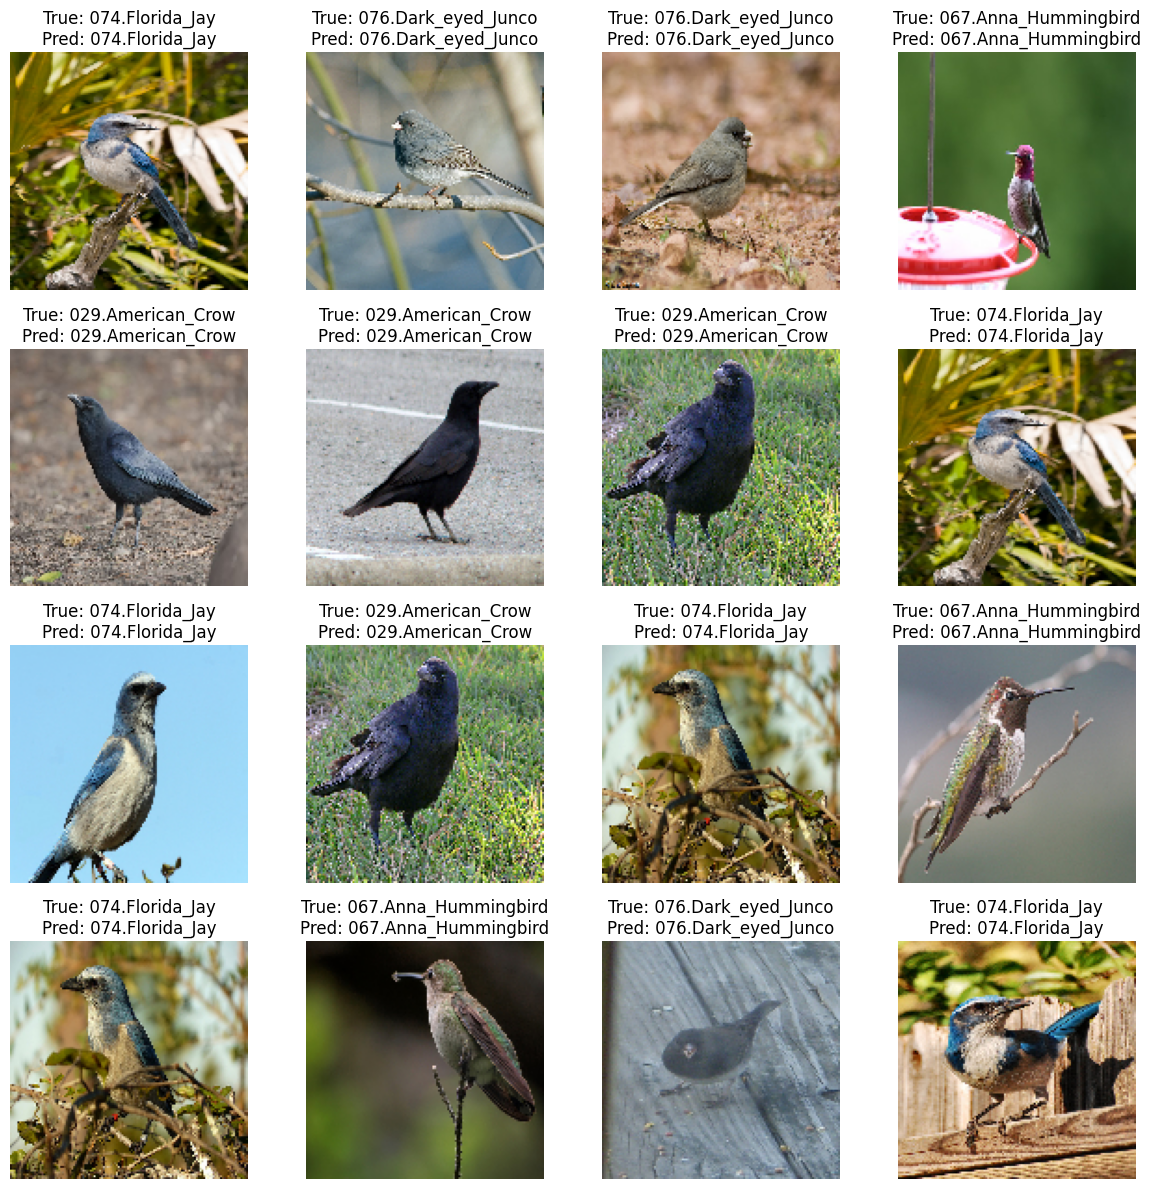

In [36]:
import matplotlib.pyplot as plt
import random

# Plot a few test images with their predicted and true labels
def plot_predictions(generator, predictions, true_labels, class_indices):
    class_names = list(class_indices.keys())
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.flatten()

    for img, ax in zip(range(len(predictions)), axes):
        img_index = random.randint(0, len(predictions) - 1)
        image, label = generator[0][0][img_index], true_labels[img_index]
        prediction = predictions[img_index]

        ax.imshow(image)
        ax.set_title(f"True: {class_names[label]}\nPred: {class_names[prediction]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_predictions(test_generator, predicted_labels, true_labels, test_generator.class_indices)